In [ ]:
import os
import glob
import torch
import shutil
import random
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

# Enable CUDA
assert torch.cuda.is_available(), "CUDA is not available. Please check your GPU configuration."
device = torch.device("cuda")
print(f"Using device: {device}")

# Define dataset path
data_dir = "/mnt/data/student_attention_dataset"
img_size = 224
classes = ['Attentive', 'Distracted', 'Sleepy', 'Bullying', 'Daydreaming', 'Hand_raising', 'Phone_use']

# Create PyTorch datasets from YOLOv7 format
image_paths = []
labels = []

for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(data_dir, split, 'labels')
    image_dir = os.path.join(data_dir, split, 'images')
    
    for label_file in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                class_id = int(line.strip().split()[0])
                image_file = label_file.replace('labels', 'images').replace('.txt', '.jpg')
                if os.path.exists(image_file):
                    image_paths.append(image_file)
                    labels.append(class_id)

# Split for custom PyTorch loader
train_x, val_x, train_y, val_y = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Define PyTorch Dataset
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_dataset = EmotionDataset(train_x, train_y, transform)
val_dataset = EmotionDataset(val_x, val_y, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Using device: cuda
Total images: 6278
Label distribution: Counter({2: 2617, 0: 1755, 4: 1057, 5: 640, 3: 193, 1: 16})


In [ ]:
assert torch.cuda.is_available(), "CUDA is not available. Please check your GPU configuration."
device = torch.device("cuda")
print(f"Using device: {device}")

# Unzip and define dataset path

data_dir = "AttentionTracking"
img_size = 224
classes = ['Attentive', 'Distracted', 'Sleepy', 'Bullying', 'Daydreaming', 'Hand_raising', 'Phone_use']

# Create PyTorch datasets from YOLOv7 format
image_paths = []
labels = []

for split in ['train', 'valid', 'test']:
    label_dir = os.path.join(data_dir, split, 'labels')
    image_dir = os.path.join(data_dir, split, 'images')

    for label_file in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(label_file, 'r') as f:
            for line in f.readlines():
                class_id = int(line.strip().split()[0])
                image_file = label_file.replace('labels', 'images').replace('.txt', '.jpg')
                if os.path.exists(image_file):
                    image_paths.append(image_file)
                    labels.append(class_id)

# Split for custom PyTorch loader
train_x, val_x, train_y, val_y = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Define PyTorch Dataset
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = EmotionDataset(train_x, train_y, transform)
val_dataset = EmotionDataset(val_x, val_y, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Using device: cuda


In [ ]:
import torch.nn as nn
import torchvision.models as models

# Use Transfer Learning - ResNet18
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\hafyz\Desktop\PyChharm\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hafyz\Desktop\PyChharm\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Compute class weights
class_counts = Counter(train_y)
total = sum(class_counts.values())
weights = [total / class_counts[i] if class_counts[i] != 0 else 0.0 for i in range(len(classes))]
class_weights = torch.tensor(weights).float().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)


In [43]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

train_loss, val_loss = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss/len(train_loader))

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss.append(val_running_loss/len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_loss[-1]:.4f}, Val Loss = {val_loss[-1]:.4f}")

# Save model
torch.save(model.state_dict(), "emotion_model.pth")

100%|██████████| 157/157 [00:54<00:00,  2.88it/s]


Epoch 1: Train Loss = 0.6619, Val Loss = 0.5477


100%|██████████| 157/157 [00:57<00:00,  2.73it/s]


Epoch 2: Train Loss = 0.5368, Val Loss = 0.5365


100%|██████████| 157/157 [00:56<00:00,  2.76it/s]


Epoch 3: Train Loss = 0.5079, Val Loss = 0.5450


100%|██████████| 157/157 [00:55<00:00,  2.82it/s]


Epoch 4: Train Loss = 0.4907, Val Loss = 0.5296


100%|██████████| 157/157 [00:56<00:00,  2.80it/s]


Epoch 5: Train Loss = 0.4906, Val Loss = 0.5405


100%|██████████| 157/157 [00:59<00:00,  2.62it/s]


Epoch 6: Train Loss = 0.4736, Val Loss = 0.5880


100%|██████████| 157/157 [00:57<00:00,  2.75it/s]


Epoch 7: Train Loss = 0.4690, Val Loss = 0.5695


100%|██████████| 157/157 [00:56<00:00,  2.79it/s]


Epoch 8: Train Loss = 0.4678, Val Loss = 0.5560


100%|██████████| 157/157 [00:58<00:00,  2.69it/s]


Epoch 9: Train Loss = 0.4577, Val Loss = 0.5981


100%|██████████| 157/157 [00:58<00:00,  2.70it/s]


Epoch 10: Train Loss = 0.4538, Val Loss = 0.5896


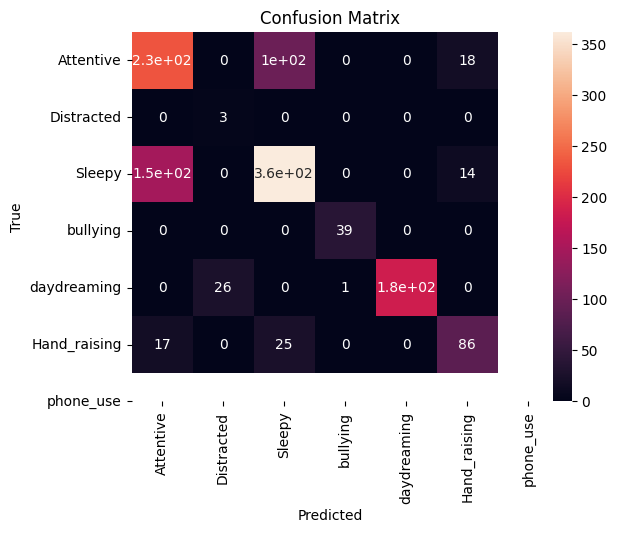

ValueError: Number of classes, 6, does not match size of target_names, 7. Try specifying the labels parameter

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=classes))


In [44]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        class_id = torch.argmax(probs).item()
        return classes[class_id], probs[class_id].item()

# Example
img_path = val_x[0]
pred_class, confidence = predict_image(img_path)
print(f"Prediction: {pred_class} ({confidence:.2f})")

Prediction: Sleepy (0.84)


In [47]:
import cv2
from torchvision.transforms.functional import to_tensor

# Load pre-trained face detector (Haar cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_face(face_img):
    face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)).resize((img_size, img_size))
    face_tensor = transform(face_pil).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(face_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        class_id = torch.argmax(probs).item()
        return classes[class_id], probs[class_id].item()

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and transform the whole frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(frame_rgb).resize((img_size, img_size))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        pred = torch.argmax(probs).item()
        label = f"{classes[pred]} ({probs[pred].item():.2f})"

    # Draw label on the original frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    cv2.imshow("Real-Time Emotion Classification", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [36]:
for path in random.sample(val_x, 5):
    pred, conf = predict_image(path)
    print(f"{os.path.basename(path)} → {pred} ({conf:.2f})")

frame586_jpg.rf.ae72bcaa6e4348ce30be5e9b0725b0d7.jpg → Sleepy (0.56)
sample_3_52300_jpg.rf.3664892a21b364bdd2b4996dcb341194.jpg → daydreaming (0.51)
38047340551_6e4055d098_b_jpg.rf.ccfbccbb21bed4cf28fa211c0cd9c7dd.jpg → Sleepy (0.65)
frame64_jpg.rf.c8a411d891abff2d6bf508f5692f6f0d.jpg → Attentive (0.81)
MVI_5962_frame_071_jpg.rf.3bb468ce3ad3dd22860fb489c6ccbcfc.jpg → Attentive (0.53)
